# Up/Down decon with steepest descent algorithm

This example is create to investigate the behavior of the analytical step size and how this compares to the stochastic gradient descent one

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import torch
import torchvision
import torch.nn as nn
import pylops_gpu

from scipy.sparse import csr_matrix, vstack
from scipy.signal import filtfilt,convolve
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy import misc
from torch.autograd import gradcheck
from pylops_gpu.utils.backend import device
from torch.nn import MSELoss
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import Dataset, DataLoader

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.tapers               import *
from pylops.utils.signalprocessing     import convmtx
from pylops.basicoperators             import *
from pylops.signalprocessing import *
from pylops.waveeqprocessing.wavedecomposition import *
from pylops.waveeqprocessing.oneway import PhaseShift
from pylops.waveeqprocessing.mdd import MDC, MDD
from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity  import *

from steepest import *

## Data loading

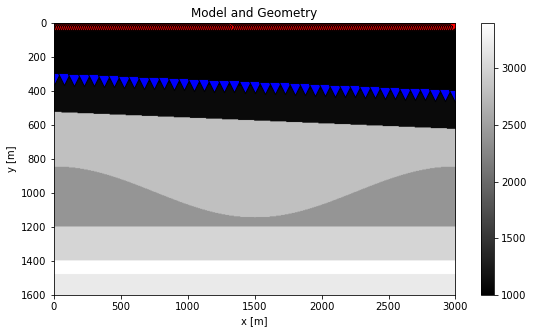

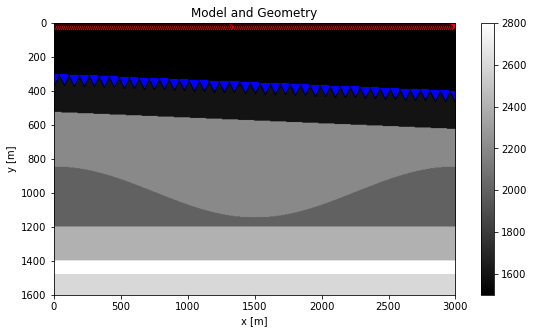

In [2]:
datapath = 'Data'

inputfile = os.path.join(datapath, 'input_dipping_recsolid.npz')

vel_dir = 1500.0 # velocity of water
vel_sep = 1600.0 # velocity at separation level
rho_sep = 1100.0 # density at separation level

#method = 'sum'
#method = 'rec_ana'
method = 'src_ana'
#method = 'src_inv'

inputdata = np.load(inputfile)

# Receivers
r = inputdata['r']
r = r[:, 201:]
nr = r.shape[1]
dr = r[0, 1]-r[0, 0]

# Sources
s = inputdata['s']
ns = s.shape[1]
ds = s[0, 1]-s[0, 0]

# Model
rho = inputdata['rho']
vel = inputdata['vel']

# Axes
nt, dt = 941, 0.005
t = np.arange(nt) * dt
x, z = inputdata['x'], inputdata['z']
dx, dz = x[1] - x[0], z[1] - z[0]

# Wavelet
wav, _, wav_c = ricker(t[0:51], 20)
wav_c = np.argmax(wav)

plt.figure(figsize=(9,5))
im = plt.imshow(rho, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(r[0, ::5],  r[1, ::5], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(s[0], s[1], marker='*', s=250, c='r', edgecolors='k')
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]'),plt.title('Model and Geometry')
plt.xlim(x[0], x[-1])
plt.ylim(z[-1], z[0])
plt.colorbar(im)

plt.figure(figsize=(9,5))
im = plt.imshow(vel, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(r[0, ::5],  r[1, ::5], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(s[0], s[1], marker='*', s=250, c='r', edgecolors='k')
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]'),plt.title('Model and Geometry')
plt.xlim(x[0], x[-1])
plt.ylim(z[-1], z[0])
plt.colorbar(im);

Up/down separated data

In [3]:
data = np.load(os.path.join(datapath, 'updown_dipping_belowseabed_%s.npz'% method))

pup = data['pup'] 
pdown = data['pdown'] 

Reference Reflection response

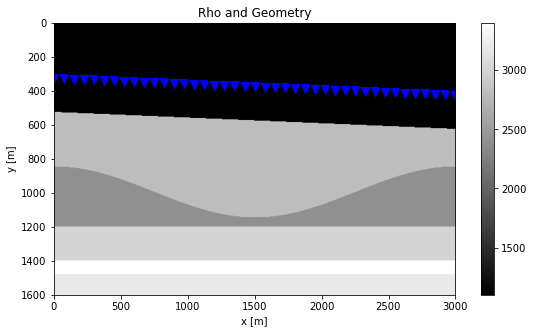

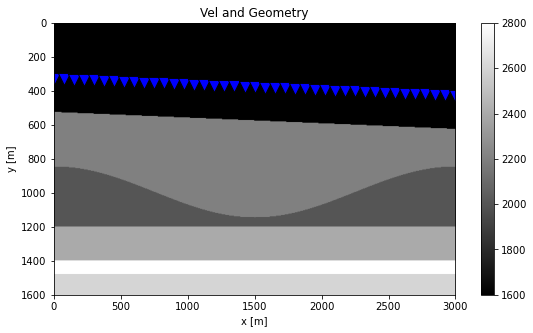

In [4]:
inputfile = os.path.join(datapath, 'input_dipping_noseabed_recsolid.npz')
inputdata = np.load(inputfile)

# data
R = -inputdata['vz_noseabed']

# Model
rho_ref = inputdata['rho_noseabed']
vel_ref = inputdata['vel_noseabed']

plt.figure(figsize=(9,5))
im = plt.imshow(rho_ref, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(r[0, ::5],  r[1, ::5], marker='v', s=150, c='b', edgecolors='k')
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]'),plt.title('Rho and Geometry')
plt.xlim(x[0], x[-1])
plt.ylim(z[-1], z[0])
plt.colorbar(im)

plt.figure(figsize=(9,5))
im = plt.imshow(vel_ref, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(r[0, ::5],  r[1, ::5], marker='v', s=150, c='b', edgecolors='k')
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]'),plt.title('Vel and Geometry')
plt.xlim(x[0], x[-1])
plt.ylim(z[-1], z[0])
plt.colorbar(im);

## Data preparation

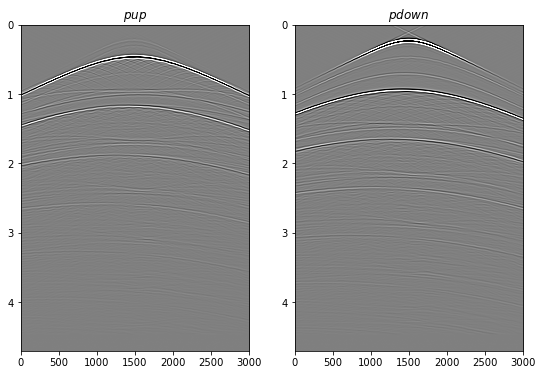

In [5]:
# Pad data with zero at the end (to avoid wrap around)
npad = 50 # 400
pdown = np.pad(pdown, ((0, 0), (0, npad), (0, 0)))#.astype('float32')
pup = np.pad(pup, ((0, 0), (0, npad), (0, 0)))#.astype('float32')
R = np.pad(R, ((1, npad), (0, 0) ))#.astype('float32')
ntpad = pup.shape[1]
tpad = np.arange(ntpad) * dt
tpad2 = np.hstack((-tpad[::-1], tpad[1:]))


fig, axs = plt.subplots(1, 2, figsize=(9,6))
axs[0].imshow(pup[ns//2], cmap='gray', vmin=-0.1*np.abs(pdown).max(), vmax=0.1*np.abs(pdown).max(),
              extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[0].set_title(r'$pup$')
axs[0].axis('tight')
axs[1].imshow(pdown[ns//2], cmap='gray', vmin=-0.1*np.abs(pdown).max(), vmax=0.1*np.abs(pdown).max(),
              extent = (r[0,0], r[0,-1], t[-1], t[0]))
axs[1].set_title(r'$pdown$')
axs[1].axis('tight');

In [6]:
# Rescale data to of amplitude around 1
scaling = 5
pdown *= scaling
pup *= scaling

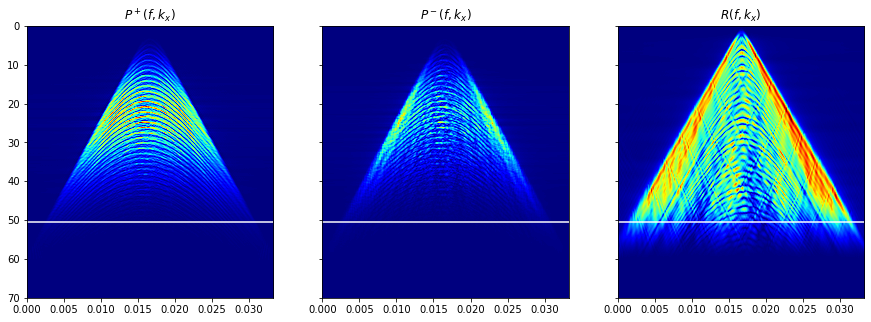

In [7]:
# check max frequency to use
nfmax=250#550
nfft = ntpad#2**11

FFTop = FFT2D(dims=[nr, ntpad], nffts=[nfft, nfft], sampling=[dr, dt])
PUP = (FFTop*pup[ns//2].T.flatten()).reshape(nfft, nfft)
PDOWN = (FFTop*pdown[ns//2].T.flatten()).reshape(nfft, nfft)
RTRUE = (FFTop*R.T.ravel()).reshape(nfft, nfft)

# mask away high freqs
mask = np.zeros((nfft, nfft))
mask[:, :nfmax] = 1
mask[:, -nfmax:] = 1
mask = filtfilt(np.ones(50)/50, 1, mask, axis=1)
RTRUE *= mask
R = np.real(FFTop.H * RTRUE.ravel()).reshape(nr, ntpad).T

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(15,5))
im=axs[0].imshow(np.fft.fftshift(np.abs(PDOWN[:, :nfft//2-1]),axes=0).T, cmap='jet', interpolation='sinc',
                 extent = (FFTop.f1[0], FFTop.f1[nfft//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]),
                 vmin=0, vmax=np.abs(PDOWN).max())
axs[0].axhline(FFTop.f2[nfmax], color='w')
axs[0].set_title(r'$P^+(f, k_x)$')
axs[0].axis('tight')
im=axs[1].imshow(np.fft.fftshift(np.abs(PUP[:, :nfft//2-1]),axes=0).T, cmap='jet', interpolation='sinc',
                 extent = (FFTop.f1[0], FFTop.f1[nfft//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]),
                 vmin=0, vmax=np.abs(PDOWN).max())
axs[1].axhline(FFTop.f2[nfmax], color='w')
axs[1].set_title(r'$P^-(f, k_x)$')
axs[1].axis('tight')
im=axs[2].imshow(np.fft.fftshift(np.abs(RTRUE[:, :nfft//2-1]),axes=0).T, cmap='jet', interpolation='sinc',
                 extent = (FFTop.f1[0], FFTop.f1[nfft//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]),
                 vmin=0, vmax=np.abs(RTRUE).max())
axs[2].axhline(FFTop.f2[nfmax], color='w')
axs[2].set_title(r'$R(f, k_x)$')
axs[2].axis('tight')
axs[2].set_ylim(70, 0);

## Steepest descent MDD

In [8]:
def errnorm(m, mtrue, enorm):
    mmax =  m.max() if m.max() != 0 else 1
    enorm.append(np.linalg.norm(m/mmax - mtrue/mtrue.max()))

In [9]:
PDOWN = np.fft.rfft(pdown.transpose(1, 0, 2), ntpad, axis=0)
PDOWN = PDOWN[:nfmax]

MDCop = MDC(PDOWN, nt=ntpad,
            nv=1, dt=dt, dr=1, # seems like forcing this to 1 gives me a good match.. need to check why
            twosided=False, transpose=False)

# Adjoint
Radj = MDCop.H * pup[:, :, nr//2].T.ravel()
Radj = np.real(Radj).reshape(ntpad, nr).T

np.linalg.norm(Radj)

4736.667070451646

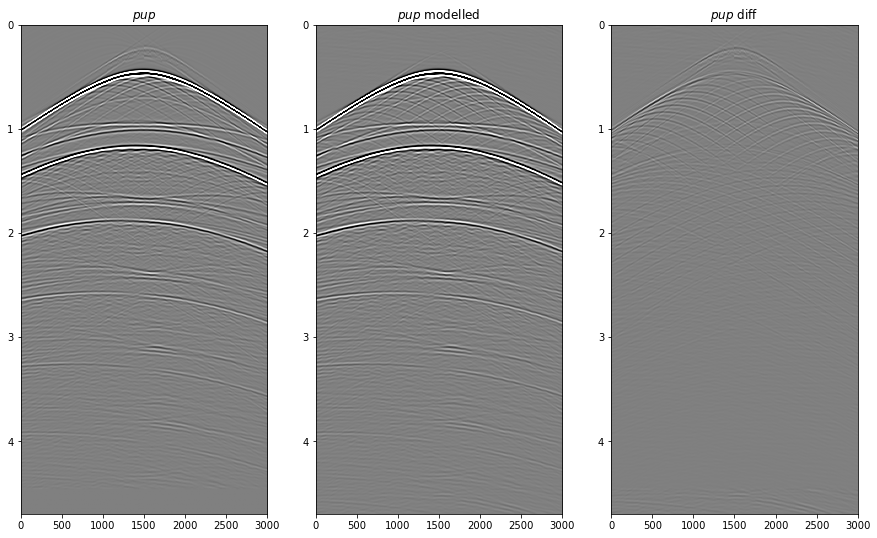

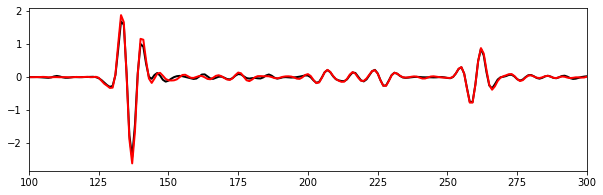

In [10]:
# Remodelled data (to investigate possible scaling issues)
pup_mod = MDCop @ R.ravel()
pup_mod = pup_mod.reshape(ntpad, nr)

fig, axs = plt.subplots(1, 3, figsize=(15, 9))
axs[0].imshow(pup[:, :, nr//2].T, cmap='gray', vmin=-0.1*np.abs(pup).max(), vmax=0.1*np.abs(pup).max(),
              extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[0].set_title(r'$pup$')
axs[0].axis('tight')
axs[1].imshow(pup_mod, cmap='gray', vmin=-0.1*np.abs(pup).max(), vmax=0.1*np.abs(pup).max(),
              extent = (r[0,0], r[0,-1], t[-1], t[0]))
axs[1].set_title(r'$pup$ modelled')
axs[1].axis('tight');
axs[2].imshow(pup_mod-pup[:, :, nr//2].T, cmap='gray', vmin=-0.1*np.abs(pup).max(), vmax=0.1*np.abs(pup).max(),
              extent = (r[0,0], r[0,-1], t[-1], t[0]))
axs[2].set_title(r'$pup$ diff')
axs[2].axis('tight');

plt.figure(figsize=(10, 3))
plt.plot(pup[50, :, nr//2], 'k', lw=2)
plt.plot(pup_mod[:, 50], 'r', lw=2)
plt.xlim(100, 300);

In [11]:
# Invert
niter = 20

# analytical stepsize
m0 = np.zeros((ntpad, nr)).ravel()
Rinv, Rinv_res, alphaana = steepest_descent(MDCop.H @ MDCop, MDCop.H @ pup[:, :, nr//2].T.ravel(), 
                                            niter=niter, m0=m0, a=None, tol=1e-3, savemhist=False)
Rinv = np.real(Rinv).reshape(ntpad, nr).T

pupinv = MDCop * Rinv.ravel()
pupinv = pupinv.reshape(ntpad, ns)

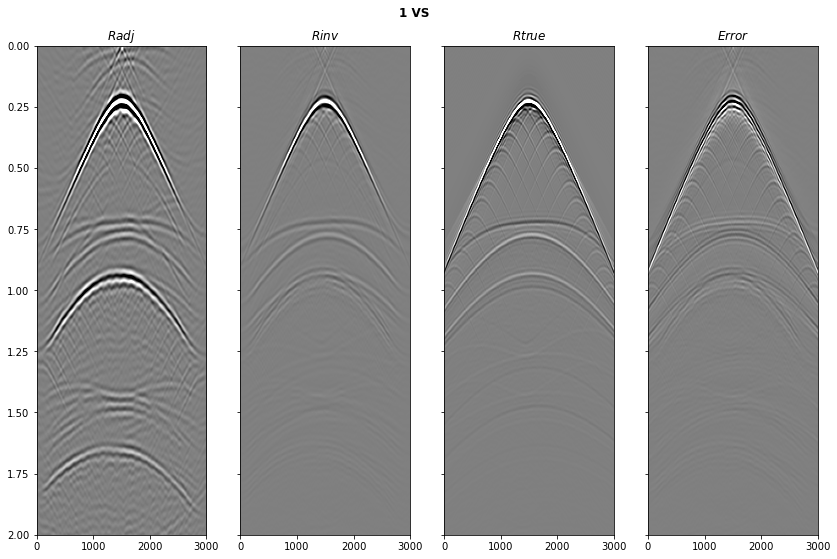

In [12]:
fig, axs = plt.subplots(1, 4, sharey=True, figsize=(14,9))
fig.suptitle('1 VS', fontweight='bold', y=0.94)
axs[0].imshow(Radj.T, cmap='gray', 
              vmin=-0.2*np.abs(Radj).max(), vmax=0.2*np.abs(Radj).max(),
              extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[0].set_title(r'$Radj$')
axs[0].axis('tight')
axs[1].imshow(Rinv.T, cmap='gray', 
              vmin=-0.2*np.abs(R).max(), vmax=0.2*np.abs(R).max(),
              extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[1].set_title(r'$Rinv$')
axs[1].axis('tight')
axs[2].imshow(R, cmap='gray', 
              vmin=-0.2*np.abs(R).max(), vmax=0.2*np.abs(R).max(),
              extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[2].set_title(r'$Rtrue$')
axs[2].axis('tight')
axs[2].set_ylim(2, -2)
axs[3].imshow(Rinv.T-R, cmap='gray', 
              vmin=-0.2*np.abs(R).max(), vmax=0.2*np.abs(R).max(),
              extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[3].set_title(r'$Error$')
axs[3].axis('tight')
axs[3].set_ylim(2, 0);

Eigenvalues of the Reflection response

In [13]:
eigmax = (MDCop.H @ MDCop).eigs(neigs=1)
eigmax

array([16749.48184727+0.j])

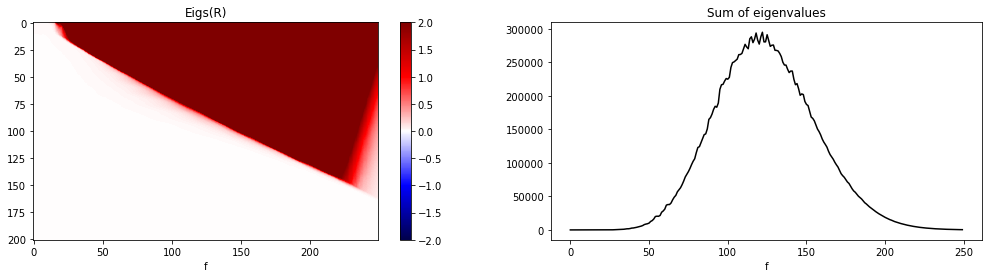

In [14]:
PDOWN = dt * np.sqrt(ntpad) * np.fft.rfft(pdown.transpose(1, 0, 2), ntpad, axis=0)
PDOWN = PDOWN[:nfmax]

eigs = np.linalg.eig(np.matmul(np.conj(PDOWN.transpose(0,2,1)), PDOWN))[0]
eigs = np.fliplr(np.sort(np.abs(eigs), axis=1))

fig, axs = plt.subplots(1, 2, figsize=(17, 4))
im = axs[0].imshow(eigs.T, cmap='seismic', vmin=-2, vmax=2)
axs[0].set_title('Eigs(R)')
axs[0].set_xlabel('f')
axs[0].axis('tight')
plt.colorbar(im, ax=axs[0])
axs[1].plot(np.sum(eigs, axis=1), 'k')
axs[1].set_title('Sum of eigenvalues')
axs[1].set_xlabel('f');

0.00011940667885951454 0.00011940667885951449


array([0.00013012, 0.00013013, 0.00011033, 0.00011674, 0.00010781,
       0.0001169 , 0.00010854, 0.00011782, 0.00010927, 0.00011859,
       0.00010986, 0.00011922, 0.00011035, 0.00011975, 0.00011077,
       0.00012021, 0.00011114, 0.00012061, 0.00011145, 0.00012096])

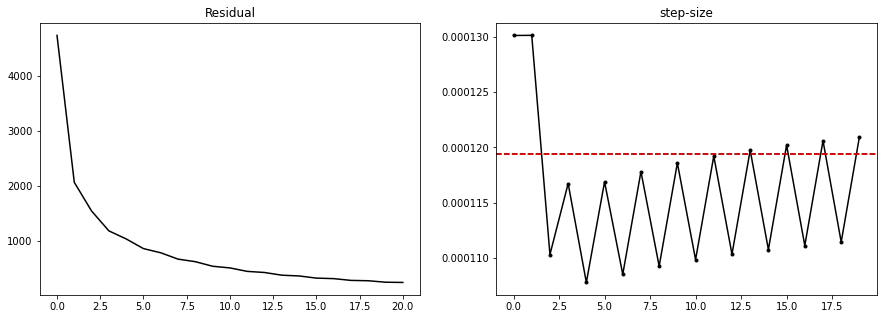

In [15]:
alphamax1 = 2. / eigs.max() 
alphamax = 2. / np.real(eigmax[0])
print(alphamax1, alphamax)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(Rinv_res, 'k')
axs[0].set_title('Residual')
axs[1].plot(alphaana, '.-k')
axs[1].axhline(alphamax, c='k', linestyle='--')
axs[1].axhline(alphamax1, c='r', linestyle='--')
axs[1].set_title('step-size');

alphaana

In [16]:
# fixed stepsize inversion
alphamax = 1.9 / np.real(eigmax[0])
m0 = np.zeros((ntpad, nr)).ravel()
Rinv, Rinv_res, alphaana = steepest_descent(MDCop.H @ MDCop, MDCop.H @ pup[:, :, nr//2].T.ravel(), 
                                            niter=niter, m0=m0, a=alphamax, tol=1e-3, savemhist=False)
Rinv = np.real(Rinv).reshape(ntpad, nr).T

pupinv = MDCop * Rinv.ravel()
pupinv = pupinv.reshape(ntpad, ns)

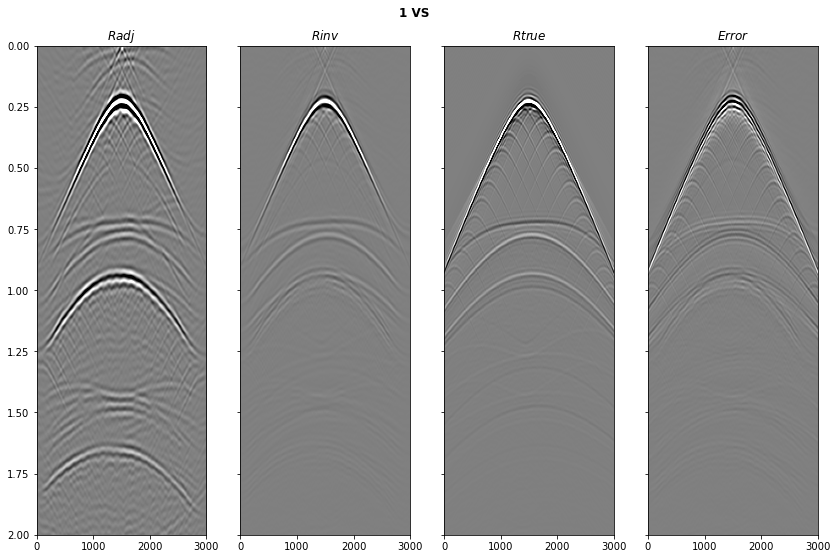

In [17]:
fig, axs = plt.subplots(1, 4, sharey=True, figsize=(14,9))
fig.suptitle('1 VS', fontweight='bold', y=0.94)
axs[0].imshow(Radj.T, cmap='gray', 
              vmin=-0.2*np.abs(Radj).max(), vmax=0.2*np.abs(Radj).max(),
              extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[0].set_title(r'$Radj$')
axs[0].axis('tight')
axs[1].imshow(Rinv.T, cmap='gray', 
              vmin=-0.2*np.abs(R).max(), vmax=0.2*np.abs(R).max(),
              extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[1].set_title(r'$Rinv$')
axs[1].axis('tight')
axs[2].imshow(R, cmap='gray', 
              vmin=-0.2*np.abs(R).max(), vmax=0.2*np.abs(R).max(),
              extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[2].set_title(r'$Rtrue$')
axs[2].axis('tight')
axs[2].set_ylim(2, -2)
axs[3].imshow(Rinv.T-R, cmap='gray', 
              vmin=-0.2*np.abs(R).max(), vmax=0.2*np.abs(R).max(),
              extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[3].set_title(r'$Error$')
axs[3].axis('tight')
axs[3].set_ylim(2, 0);